# Детекция объектов и методы обработки

В этом ноутбуке рассматриваются базовые и продвинутые методы детекции объектов. Цель — познакомиться с различными алгоритмами выделения признаков, оценки перекрытия и подавления ложных срабатываний, а также попробовать предобученные нейросети для обнаружения объектов.

**Вы изучите:**

- использование гистограмм ориентированных градиентов (HOG) для извлечения признаков и линейный классификатор SVM;
- влияние настроек HOG‐признаков (число ориентиров, размеры ячеек и блоков) на точность классификатора;
- вычисление метрики пересечения/объединения (IoU) и алгоритм подавления немаксимумов (NMS) для устранения множественных откликов;
- построение кривых точности‑полноты (PR‑кривых) для детекторов с различными распределениями скор;
- поиск объектов методом корреляции с шаблоном (Normalized Cross‑Correlation) и оценка устойчивости к шуму;
- запуск детекции с помощью предобученной нейросети (например, YOLOv5) и визуализация результатов.

Каждый раздел содержит текстовые пояснения и рабочий код, который вы можете модифицировать и запускать на своих данных."


In [ ]:
# Установка необходимых библиотек (раскомментируйте при первом запуске)
# !pip install ultralytics

Заметим, что увеличение числа ориентиров (с 8 до 9) и изменение размера ячеек влияют на точность классификации. Меньшие ячейки \((4	imes 4)\) позволяют захватить более детальные градиентные структуры, что улучшает точность. При слишком крупных блоках качество может падать из‑за потери локальной информации. Эти эксперименты помогают подобрать компромисс между количеством признаков и качеством.


## 1. IoU и NMS: борьба с множественными откликами

Метрика Intersection over Union (IoU) измеряет степень перекрытия двух ограничивающих рамок. П
усть \(A\) и \(B\) — две рамки. IoU определяют как

$$
\mathrm{IoU}(A,B)=\frac{|A\cap B|}{|A\cup B|}
$$

Алгоритм подавления немаксимумов (Non‑Maximum Suppression, NMS) нужен, чтобы из множества перекрывающихся детекций оставить наиболее вероятные. Алгоритм сортирует рамки по уверенности, затем последовательно выбирает рамку с максимальным счётом и подавляет все рамки с высокой степенью перекрытия (IoU выше порога). Ниже приведена реализация IoU и NMS с визуализацией результатов для разных порогов.


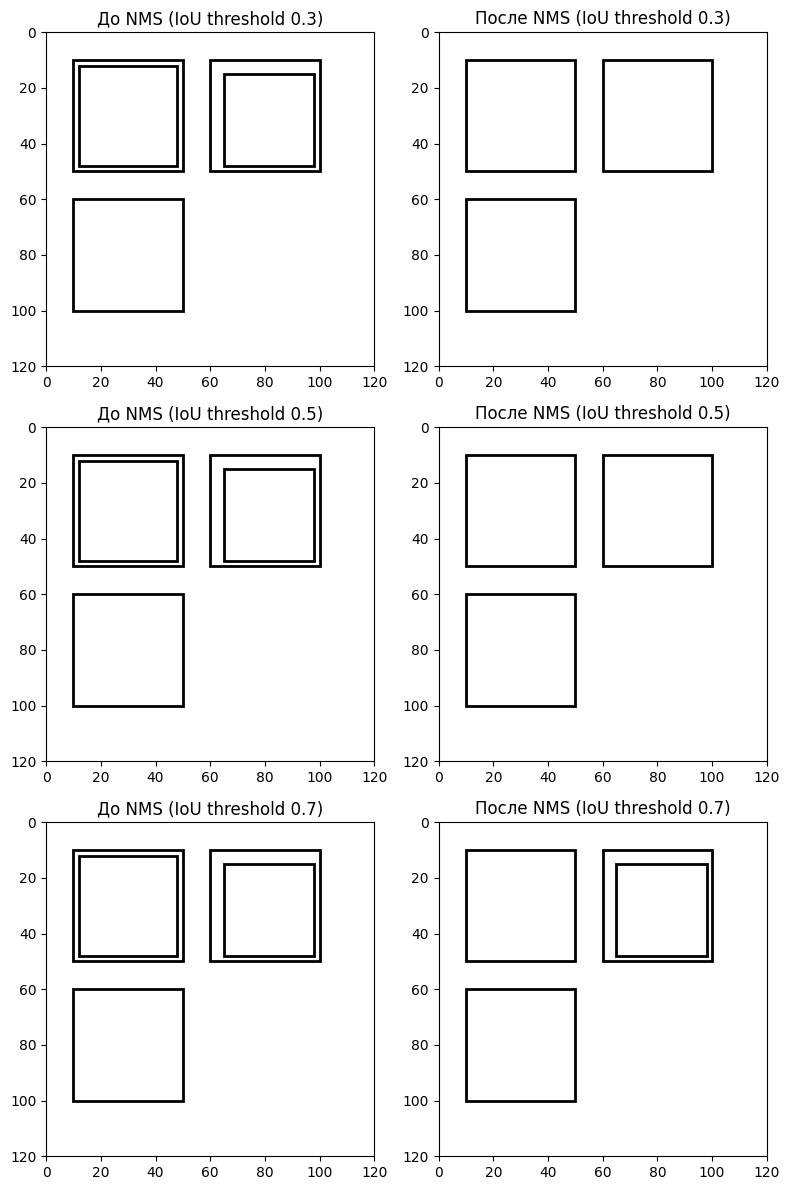

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для вычисления IoU двух рамок [x1,y1,x2,y2]
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    a1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
    a2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union = a1 + a2 - inter
    return inter / union if union > 0 else 0.0

# Алгоритм NMS
def nms(boxes, scores, iou_thresh=0.5):
    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        rest = idxs[1:]
        suppress = []
        for j in rest:
            if iou(boxes[i], boxes[j]) > iou_thresh:
                suppress.append(j)
        idxs = np.array([k for k in rest if k not in suppress])
    return keep

# Пример наборов рамок и уверенности
test_boxes = np.array([
    [10,10,50,50], [12,12,48,48], [60,10,100,50], [65,15,98,48], [10,60,50,100],
])
test_scores = np.array([0.9, 0.85, 0.8, 0.7, 0.6])

def plot_boxes(ax, boxes, title):
    for b in boxes:
        x1,y1,x2,y2 = b
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
    ax.set_xlim(0,120); ax.set_ylim(0,120); ax.invert_yaxis()
    ax.set_title(title)

# Визуализируем результат NMS для разных порогов
thresholds = [0.3, 0.5, 0.7]
fig, axes = plt.subplots(len(thresholds), 2, figsize=(8, 4*len(thresholds)))
for i, thr in enumerate(thresholds):
    keep_idx = nms(test_boxes, test_scores, iou_thresh=thr)
    # До NMS
    plot_boxes(axes[i,0], test_boxes, f"До NMS (IoU threshold {thr})")
    # После NMS
    plot_boxes(axes[i,1], test_boxes[keep_idx], f"После NMS (IoU threshold {thr})")
plt.tight_layout()
plt.show()


## 3. Кривые точности‑полноты (PR‑кривые)

PR‑кривая отображает зависимость точности (Precision) от полноты (Recall) при разных порогах уверенности. Точность показывает долю верных детекций среди всех детекций, а полнота — долю найденных объектов среди всех истинных объектов. Хороший детектор стремится к высокой точности и полноте.

В этом примере мы смоделируем два детектора с разными распределениями оценок: один «лучший» (высокие баллы для истинных объектов), второй «хуже» (баллы более смешаны). Затем построим для них PR‑кривые."


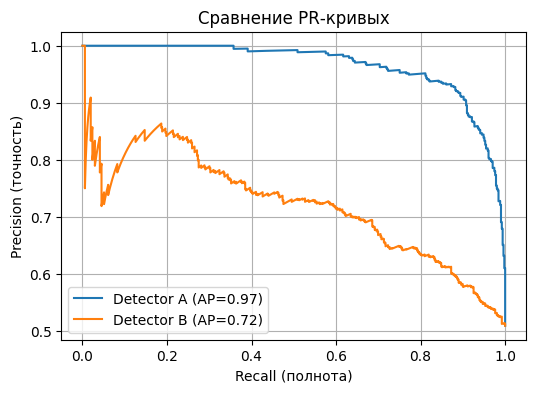

In [4]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Генерируем имитацию оценок двух детекторов для 1000 примеров
rng = np.random.default_rng(42)
# Случайные истинные метки (0 — фон, 1 — объект)
y_true = rng.integers(0, 2, size=1000)

# Детектор A: высокие баллы для объектов, низкие для фона
scores_a = rng.normal(loc=0.7, scale=0.2, size=1000) * y_true + rng.normal(loc=0.2, scale=0.2, size=1000) * (1 - y_true)
# Детектор B: распределения баллов больше перекрываются
scores_b = rng.normal(loc=0.6, scale=0.25, size=1000) * y_true + rng.normal(loc=0.4, scale=0.25, size=1000) * (1 - y_true)

# Вычисляем PR‑кривые
prec_a, rec_a, _ = precision_recall_curve(y_true, scores_a)
prec_b, rec_b, _ = precision_recall_curve(y_true, scores_b)

ap_a = average_precision_score(y_true, scores_a)
ap_b = average_precision_score(y_true, scores_b)

# Рисуем
plt.figure(figsize=(6,4))
plt.plot(rec_a, prec_a, label=f'Detector A (AP={ap_a:.2f})')
plt.plot(rec_b, prec_b, label=f'Detector B (AP={ap_b:.2f})')
plt.xlabel('Recall (полнота)')
plt.ylabel('Precision (точность)')
plt.title('Сравнение PR‑кривых')
plt.legend()
plt.grid(True)
plt.show()


## 4. Поиск объектов методом шаблонов (Normalized Cross‑Correlation, NCC)

Нормированная взаимная корреляция — простой и эффективный метод поиска известных объектов на изображении. Вы берёте шаблон и сдвигаете его по исходному изображению, вычисляя коэффициент корреляции в каждой позиции. При помощи функции `skimage.feature.match_template` можно найти максимум корреляции и локализовать шаблон.

В следующих ячейках мы загрузим изображение, выберем в нём фрагмент в качестве шаблона, найдём его на исходном изображении и посмотрим, как добавление шума влияет на результат.


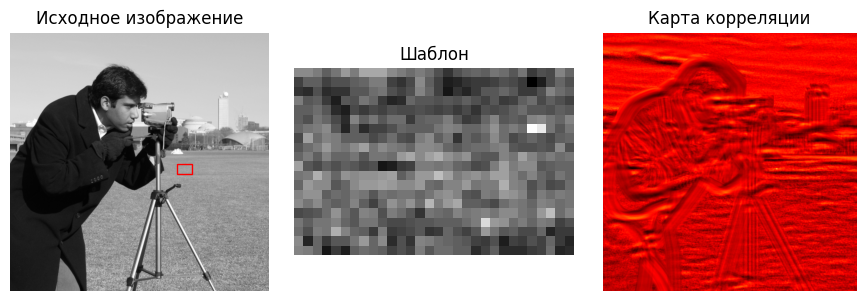

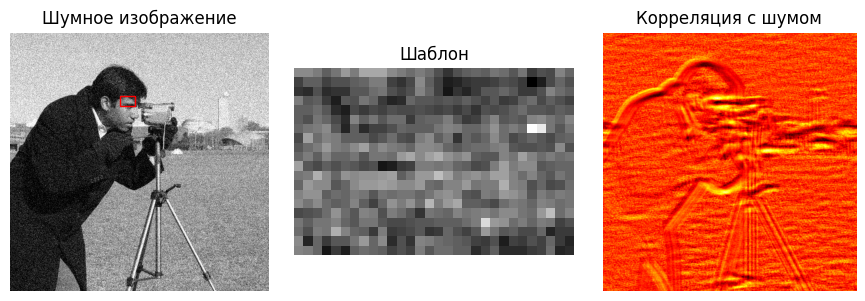

In [5]:
from skimage import data, img_as_float
from skimage.feature import match_template
from skimage.util import random_noise
import matplotlib.pyplot as plt

# Загружаем пример изображения и переводим в формат float
image = img_as_float(data.camera())

# Выбираем прямоугольный шаблон вручную (например, глаз на лице)
template = image[260:280, 330:360]

# Выполняем поиск шаблона
result = match_template(image, template)
i, j = np.unravel_index(np.argmax(result), result.shape)

# Визуализируем исходное изображение и шаблон
fig, axes = plt.subplots(1, 3, figsize=(9,3))
ax = axes.ravel()
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Исходное изображение')
# Нарисуем найденную область
ax[0].add_patch(plt.Rectangle((j, i), template.shape[1], template.shape[0], edgecolor='r', facecolor='none'))
ax[1].imshow(template, cmap='gray')
ax[1].set_title('Шаблон')
ax[2].imshow(result, cmap='hot')
ax[2].set_title('Карта корреляции')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# Добавляем гауссов шум к изображению и повторяем поиск
noisy_image = random_noise(image, mode='gaussian', var=0.01)
result_noisy = match_template(noisy_image, template)
i_n, j_n = np.unravel_index(np.argmax(result_noisy), result_noisy.shape)

fig, axes = plt.subplots(1, 3, figsize=(9,3))
ax = axes.ravel()
ax[0].imshow(noisy_image, cmap='gray')
ax[0].set_title('Шумное изображение')
ax[0].add_patch(plt.Rectangle((j_n, i_n), template.shape[1], template.shape[0], edgecolor='r', facecolor='none'))
ax[1].imshow(template, cmap='gray')
ax[1].set_title('Шаблон')
ax[2].imshow(result_noisy, cmap='hot')
ax[2].set_title('Корреляция с шумом')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()


### 5 Обнаружение с каскадами Хаара

Каскады Хаара могут обнаруживать не только лица, но и более мелкие элементы, такие как глаза и улыбки. В основе лежит обучение набора простых прямоугольных фильтров на множестве позитивных и негативных примеров. Для уменьшения ложных срабатываний полезно сначала искать области интереса (например, лица), а затем запускать вторичные каскады внутри этих областей.

Ниже приведён пример: мы используем предобученные классификаторы `haarcascade_eye` и `haarcascade_smile` из OpenCV. Сначала детектируются лица, затем внутри каждого лица — глаза (синие рамки) и улыбки (красные рамки). 

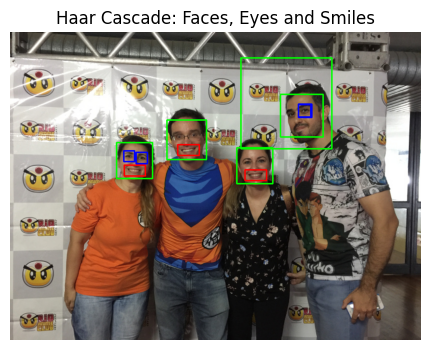

In [3]:
# Detect faces, eyes and smiles using Haar cascades
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

# Download the same sample image used earlier
url = "https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/test.jpg"
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load cascades
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
img_draw = img.copy()

# For each face, detect eyes and smiles
for (x, y, w, h) in faces:
    cv2.rectangle(img_draw, (x, y), (x + w, y + h), (0, 255, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    roi_color = img_draw[y:y + h, x:x + w]
    # Eyes
    eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=10)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (255, 0, 0), 2)
    # Smiles
    smiles = smile_cascade.detectMultiScale(roi_gray, scaleFactor=1.2, minNeighbors=15)
    for (sx, sy, sw, sh) in smiles:
        cv2.rectangle(roi_color, (sx, sy), (sx + sw, sy + sh), (0, 0, 255), 2)

# Convert to RGB for display
img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 4))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Haar Cascade: Faces, Eyes and Smiles')
plt.show()

## 6 Face Detection with Haar Cascades

Классификаторы Хаара — один из самых ранних и широко используемых методов обнаружения объектов, особенно лиц. Этот метод был предложен Виолой-Джонсом (2001). Он использует простые признаки, подобные признакам Хаара, вычисляемые в разных масштабах и положениях на изображении, и обучает классификаторы с помощью бустинга на положительных и отрицательных примерах. Во время вывода классификатор применяется по принципу скользящего окна с каскадной структурой, которая быстро отбрасывает области, не содержащие лиц. Хотя современные модели глубокого обучения превосходят каскадные модели на больших бенчмарках, они остаются быстрой и простой базой для таких задач, как обнаружение лиц.

В OpenCV предварительно обученные каскадные классификаторы Хаара можно загрузить из каталога `cv2.data.haarcascades`. Ниже мы покажем, как обнаружить лица на изображении с помощью каскадного классификатора `haarcascade_frontalface_default.xml`. Изображение загружается с GitHub и считывается в массив NumPy; Распознаются лица, и на изображении рисуются ограничивающие рамки.

Detected 5 face(s)


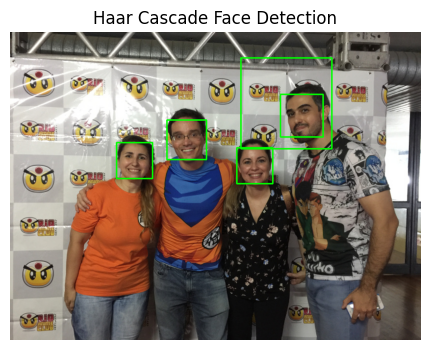

In [5]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

# Download a sample image with faces (public domain)
url = "https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/test.jpg"
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype=np.uint8)
img = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

# Convert to grayscale for detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load Haar cascade for frontal faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Perform detection (returns list of bounding boxes)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

print(f'Detected {len(faces)} face(s)')

# Draw bounding boxes on a copy of the image
img_draw = img.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(img_draw, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convert BGR to RGB for matplotlib
img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

# Display the result
plt.figure(figsize=(6, 4))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Haar Cascade Face Detection')
plt.show()


### 7 Face Detection via dlib (HOG и CNN-based)

Библиотека dlib — мощный C++/Python-фреймворк, включающий реализацию face detection, landmark detection и face alignment.
Она поддерживает два подхода:

HOG + SVM детектор (get_frontal_face_detector) — быстрый классический вариант;

CNN-детектор (cnn_face_detection_model_v1.dat) — более точный, но медленнее.

Здесь мы используем базовый HOG-детектор, включённый в dlib «из коробки».
Сначала выполним детекцию и визуализируем рамки лиц рядом с результатом Viola–Jones.

Найдено лиц: 3
Координаты первого: [(86, 96) (175, 186)]


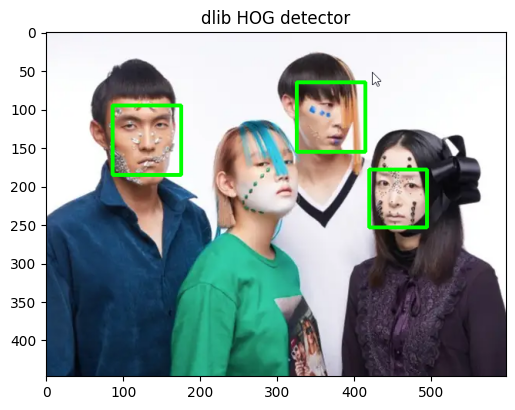

In [ ]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# тот же путь к картинке
img_path = '/home/mike/projects/study_projects/MUIV/cv_course/seminars/module04/data/faces.png'

img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
gray    = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# 1️⃣  Загружаем детектор (HOG + SVM)
detector = dlib.get_frontal_face_detector()

# 2️⃣  Запускаем детекцию (второй параметр — upsampling factor)
rects = detector(gray, 1)

print(f'Найдено лиц: {len(rects)}')
if rects:
    print('Координаты первого:', rects[0])

# 3️⃣  Вспомогательная функция перевода dlib-rect → cv2-rect
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

# 4️⃣  Визуализация
result_dlib = np.copy(img_rgb)
for rect in rects:
    x, y, w, h = rect_to_bb(rect)
    cv2.rectangle(result_dlib, (x, y), (x+w, y+h), (0, 255, 0), 3)

# Сравним с результатом Viola–Jones (если он в переменной result)
plt.figure(figsize=(10,5))
plt.subplot(122), plt.imshow(result_dlib), plt.title('dlib HOG detector')
plt.tight_layout(); plt.show()


## 8 Face Alignment (выравнивание лиц по ключевым точкам)

После того как лицо найдено, важно «нормализовать» его положение — совместить глаза, рот и другие опорные точки.
Такое выравнивание (alignment) упрощает дальнейшие задачи: распознавание, сравнение лиц, обучение эмбеддингов.

В dlib для этого используется Shape Predictor — регрессор, который по изображению лица выдаёт координаты 68 ключевых точек.
Чтобы выполнить affine-трансформацию, берут несколько характерных точек (например, углы глаз и центр рта) и приводят их к шаблону.

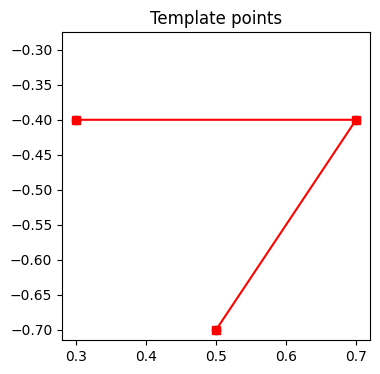

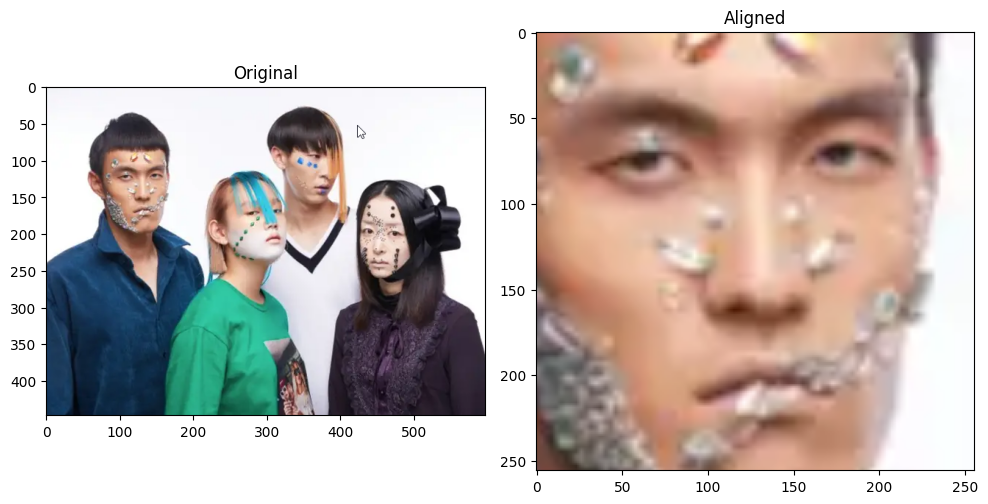

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузим шаблон точек (если имеется)
# Для примера можно просто создать синтетический шаблон:
# face_template = np.load('/home/mike/projects/study_projects/MUIV/cv_course/seminars/module04/data/face_template.npy')

face_template = np.array([
    [0.3, 0.4], [0.7, 0.4], [0.5, 0.7]
], dtype=np.float32)  # три опорные точки (глаза и рот)

plt.figure(figsize=(4,4))
plt.plot(face_template[:,0], -face_template[:,1], 'o')
plt.plot([face_template[i,0] for i in [0,1,2]],
         [-face_template[i,1] for i in [0,1,2]], 'rs-')
plt.axis('square'); plt.title('Template points'); plt.show()

# Пусть landmarks получены предиктором dlib (пример):
# predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
# shape = predictor(gray, rects[0])
# landmarks = np.array([[p.x, p.y] for p in shape.parts()], dtype=np.float32)
# landmarks_idx = [36, 45, 57]  # углы глаз и центр рта

# Для демонстрации создадим фиктивные точки внутри найденного лица
x, y, w, h = rect_to_bb(rects[0])
landmarks = np.float32([
    [x + 0.3*w, y + 0.4*h],
    [x + 0.7*w, y + 0.4*h],
    [x + 0.5*w, y + 0.7*h]
])

# Аффинное преобразование между реальными точками и шаблоном
out_size = 256
margin = 10
template = face_template * out_size
H = cv2.getAffineTransform(landmarks, template)
aligned = cv2.warpAffine(img_rgb, H, (out_size, out_size))

plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(img_rgb), plt.title('Original')
plt.subplot(122), plt.imshow(aligned), plt.title('Aligned')
plt.tight_layout(); plt.show()


## 7. Предобученная детекция объектов (YOLO)

Современные нейросетевые детекторы, такие как YOLO (You Only Look Once), позволяют обнаруживать и классифицировать объекты на изображении за один проход нейросети. В качестве примера можно использовать семейство моделей YOLOv5 или YOLOv8 из библиотеки **ultralytics**.

Ниже приведён пример использования YOLOv5s. Для работы необходимо установить пакет `ultralytics` (можно заменить на `torchvision` и использовать Faster R‑CNN).

Код загружает предобученную модель, обрабатывает изображение, а затем отображает рамки. Учтите, что выполнение требует установки пакетов и может быть ресурсоёмким."



0: 480x640 4 persons, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 640)


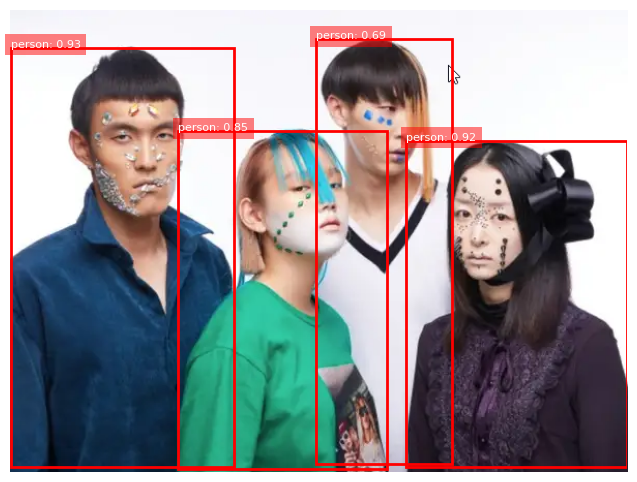

In [2]:
# Установите ultralytics, если ещё не установлено:
# pip install ultralytics

from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Загружаем улучшенную модель YOLOv5u
model = YOLO('yolov5su.pt')

# Загружаем изображение (замените путь на свой)
img_path = '/home/mike/projects/study_projects/MUIV/cv_course/seminars/module04/data/faces.png'
img = Image.open(img_path)

# Запускаем детекцию
results_list = model(img)  # вернёт список результатов

# Берём первый (и единственный) результат
results = results_list[0]

# Извлекаем координаты рамок (xyxy), номера классов и вероятности
boxes   = results.boxes.xyxy.cpu().numpy()      # [x1, y1, x2, y2] для каждой рамки
labels  = results.boxes.cls.cpu().numpy().astype(int)
scores  = results.boxes.conf.cpu().numpy()
names   = results.names                          # словарь id → имя класса

# Визуализируем исходное изображение с рамками и классами
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
for (x1, y1, x2, y2), cls_id, conf in zip(boxes, labels, scores):
    # рисуем прямоугольник
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                               edgecolor='red', facecolor='none', linewidth=2))
    # подписываем класс и вероятность
    ax.text(x1, y1, f'{names[cls_id]}: {conf:.2f}',
            color='white', fontsize=8,
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none'))
ax.axis('off')
plt.show()


## Заключение

В этом ноутбуке вы познакомились с различными методами, используемыми в задачах детекции:

- получили представление о том, как выбор параметров HOG влияет на качество линейного классификатора SVM;
- реализовали метрику IoU и алгоритм NMS для устранения множественных перекрывающихся детекций;
- построили PR‑кривые и оценили среднюю точность (AP) детекторов;
- попробовали поиск объектов шаблонным методом и увидели влияние шума на точность совпадения;
- получили пример запуска современного нейросетевого детектора YOLO.

Вы можете расширить этот notebook, протестировав свои изображения, добавив аугментации, различные нейросетевые модели и сравнив их работу на практике.
